## PCA

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
data=np.load("./input/olivetti_faces.npy")
target = np.load("./input/olivetti_faces_target.npy")

In [3]:
print(data.shape)
print("이미지 갯수: {}".format(len(data)))
print("target 수: {}".format(len(np.unique(target))))
print("각 이미지 사이즈: {}x{}".format(data.shape[1],data.shape[2]))

(400, 64, 64)
이미지 갯수: 400
target 수: 40
각 이미지 사이즈: 64x64


In [4]:
print('target 번호: ', np.unique(target))

target 번호:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [5]:
def show_targets(images, unique_ids):
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr = axarr.flatten()
    
    for unique_id in unique_ids:
        image_index = unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        plt.suptitle("40 people faces")

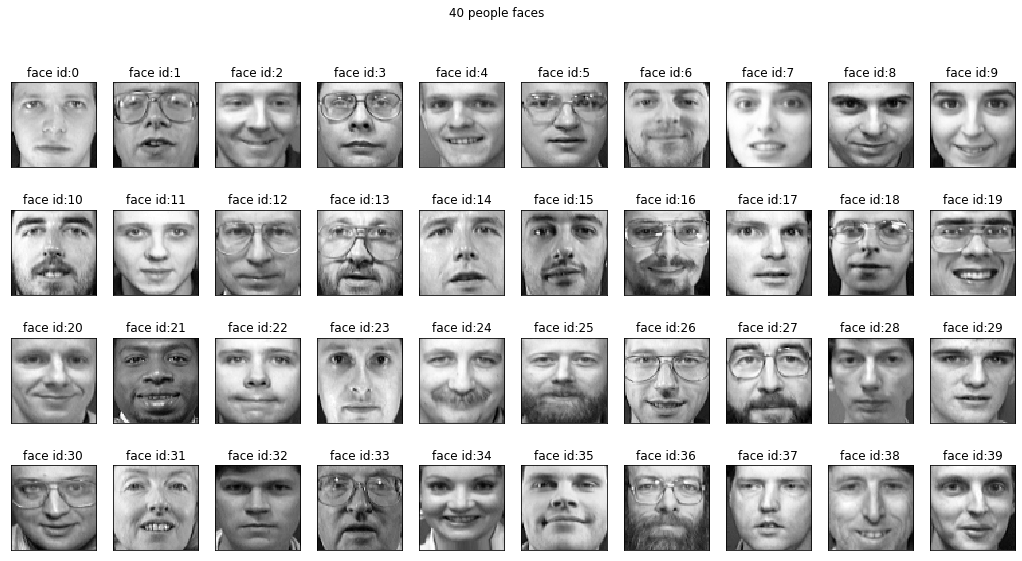

In [6]:
show_targets(data, np.unique(target))

In [7]:
def show_target(images, subject_ids):
    cols =10
    rows =(len(subject_ids)*10)/cols
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows = rows, ncols=cols, figsize=(18, 9))
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index = subject_id*10 +j
            axarr[i, j].imshow(images[image_index], cmap='gray')
            axarr[i, j].set_xticks([])
            axarr[i, j].set_yticks([])
            axarr[i, j].set_title("face_id:{}".format(subject_id))

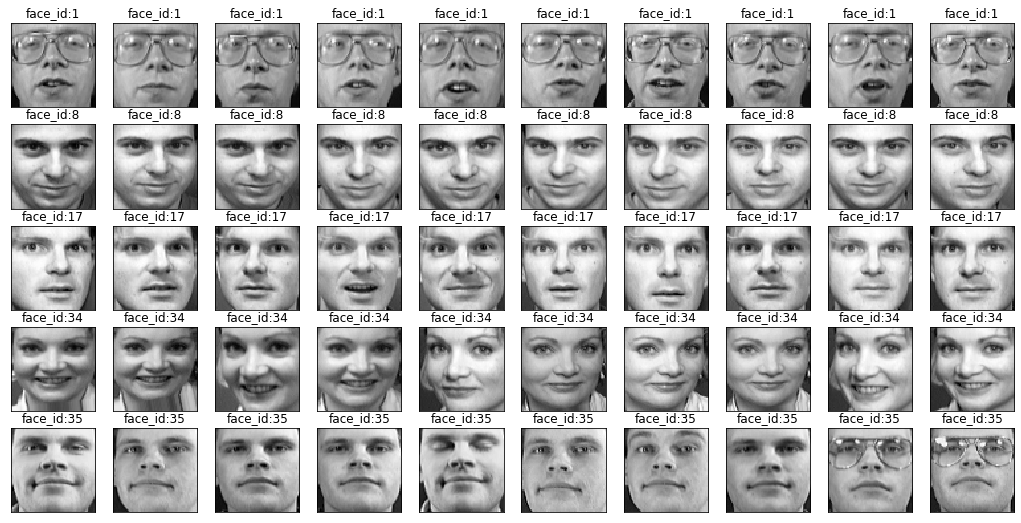

In [8]:
show_target(images=data, subject_ids = [1, 8, 17, 34, 35])

In [9]:
X=data.reshape((data.shape[0], data.shape[1]*data.shape[2]))
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size =0.2,
                                     stratify = target, random_state=0)
print(X_train.shape)
print(Y_train.shape)

(320, 4096)
(320,)


### PCA 적용해보기
PCA 클래스
n_components=입력인수 <br>
속성변수
 -> mean_(평균벡터), components_(주성분벡터)

In [10]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

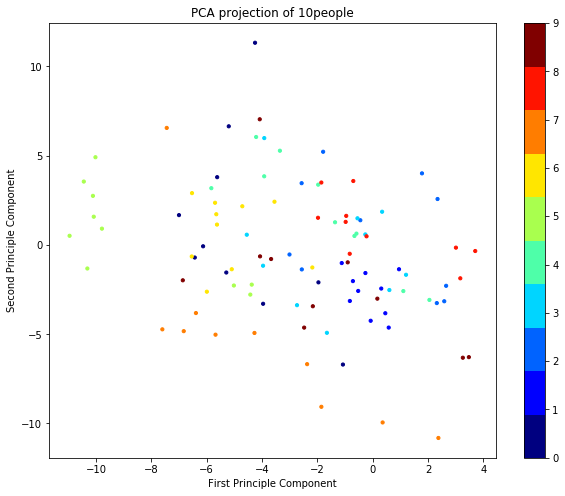

In [11]:
number_of_people = 10
index_range = number_of_people*10
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(X_pca[:index_range, 0],
                    X_pca[:index_range, 1],
                    c= target[:index_range],
                    s=10,
                    cmap=plt.get_cmap('jet', number_of_people))

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {}people".format(number_of_people))

fig.colorbar(scatter)

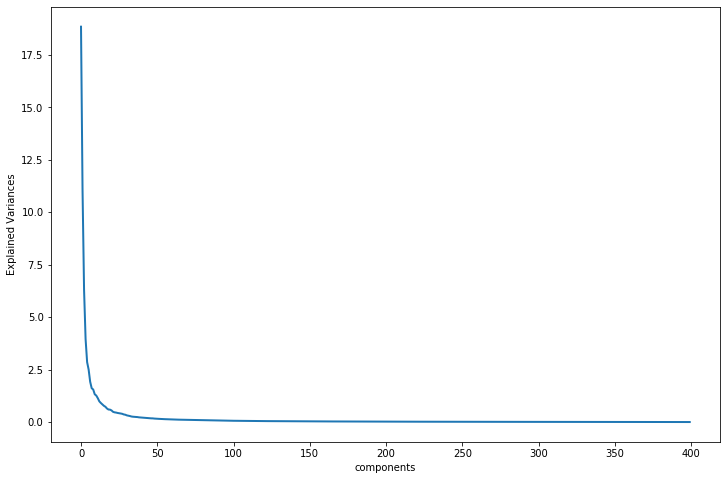

In [12]:
pca = PCA()
pca.fit(X)
plt.figure(1, figsize=(12, 8))

plt.xlabel('components')
plt.ylabel('Explained Variances')
plt.plot(pca.explained_variance_, linewidth =2)

In [56]:
n_components=10
pca = PCA(n_components = n_components, whiten = True) 
pca.fit(X_train)
X_proj = pca.fit_transform(X_train)

Text(0.5, 1.0, 'Average Face')

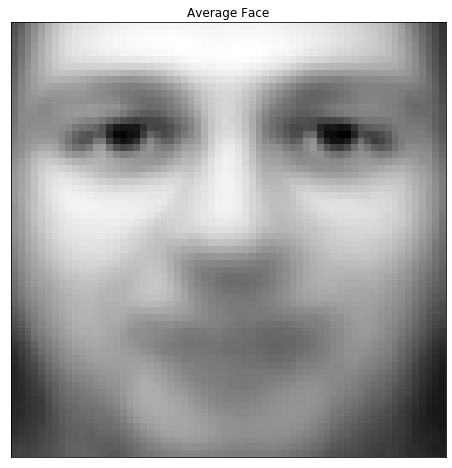

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.imshow(pca.mean_.reshape((64, 64)), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Text(0.5, 0.98, 'All Eigen Faces')

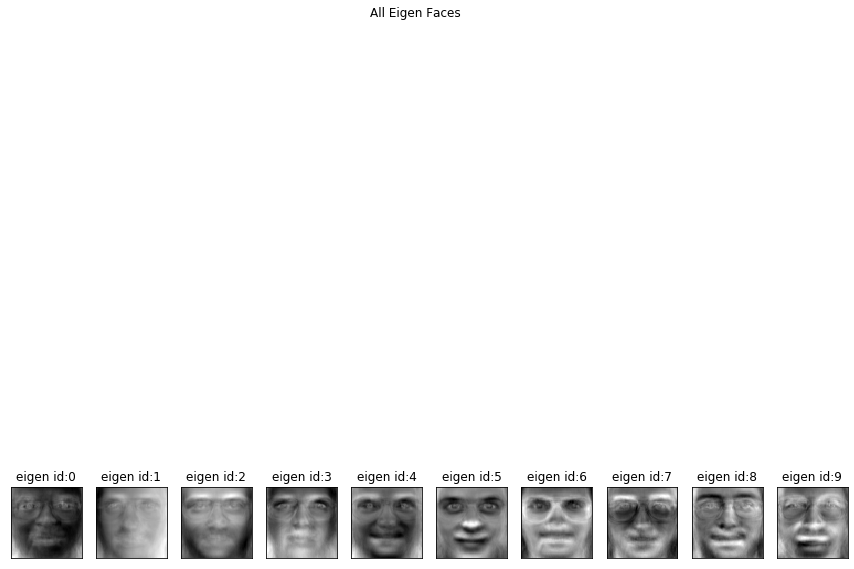

In [54]:
number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

cols=10
rows=1
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

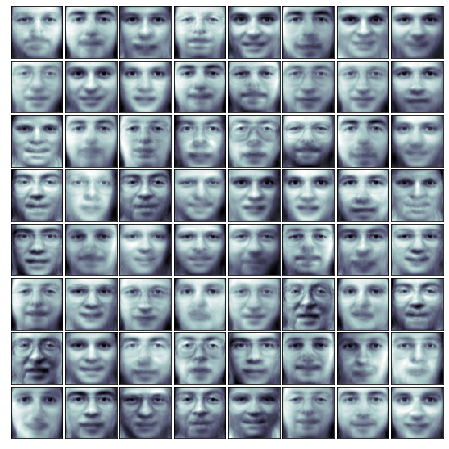

In [60]:
X_inv_proj = pca.inverse_transform(X_proj)
X_proj_img = np.reshape(X_inv_proj, (320, 64, 64))

fig =plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # plot the faces, each image is 64 by 64 dimension but 8x8 pixels 
for i in range(64): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(X_proj_img[i], cmap=plt.cm.bone, interpolation='nearest') 

In [53]:
data_=data

## VAE

In [19]:
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 2
EPOCHS = 10

# connections through the autoencoder bottleneck
ZDIMS = 200


torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # 64 * 64
        self.fc1 = nn.Linear(4096, 3000)

        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(3000, ZDIMS)  
        self.fc22 = nn.Linear(3000, ZDIMS)

        self.fc3 = nn.Linear(ZDIMS, 3000)
        self.fc4 = nn.Linear(3000, 4096)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 4096))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [20]:
model = VAE()
if CUDA:
    model.cuda()

In [21]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 4096))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 4096

    return BCE + KLD

In [28]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
target_no = 0
train_loss_val = []
test_loss_val = []
print(len(data_))

400


In [29]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_[0 + 10*target_no:10 +10*target_no]):
        data = Variable(torch.from_numpy(data))
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
    
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        train_loss_val.append(loss.data/len(data))
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx *len(data_), 8 * len(data_),
                100. * batch_idx / 8,
                loss.data/ len(data)))

    print('no.{}====> Epoch: {} Average loss: {:.4f}'.format(target_no+1,
          epoch, train_loss / len(X_train)))

In [30]:
def test(epoch):
    model.eval()
    test_loss = 0

    for i, data in enumerate(data_[9 + 10*target_no:10 +10*target_no]):
        data = torch.from_numpy(data)
        if CUDA:
            data = data.cuda()

        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
    
        test_loss += loss_function(recon_batch, data, mu, logvar).data
        if i == 0:
            n = min(data.size(0), 8)
            #print(recon_batch.shape)
            #print(data.shape)
            #comparison = torch.cat([data[:n],
            #                  recon_batch.view(-1, 1, 64, 64)[:n]])
            comparison = recon_batch.view(64, -1)
            save_image(comparison.data.cpu(),
                     'results/recon_' + str(epoch) + '_'+ str(target_no+1)+'.png', nrow=n)

    test_loss /= len(X_test)
    test_loss_val.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [31]:
while target_no<40:
    for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)
    
    
        sample = Variable(torch.randn(64, ZDIMS))
        if CUDA:
            sample = sample.cuda()
        sample = model.decode(sample).cpu()
    
        save_image(sample.data.view(-1, 64),
                   'results/sample_' + str(epoch) + '_'+str(target_no+1)+'.png')
    target_no+=1

Train Epoch: 1 [0/3200 (0%)]	Loss: 0.010285
Train Epoch: 1 [800/3200 (25%)]	Loss: 0.010441
Train Epoch: 1 [1600/3200 (50%)]	Loss: 0.009982
Train Epoch: 1 [2400/3200 (75%)]	Loss: 0.010441
Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010223
no.1====> Epoch: 1 Average loss: 0.0203
====> Test set loss: 0.0080
Train Epoch: 2 [0/3200 (0%)]	Loss: 0.010135
Train Epoch: 2 [800/3200 (25%)]	Loss: 0.010093
Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.009826
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010317
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010052
no.1====> Epoch: 2 Average loss: 0.0200
====> Test set loss: 0.0080


/home/jhoh/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


Train Epoch: 3 [0/3200 (0%)]	Loss: 0.010038
Train Epoch: 3 [800/3200 (25%)]	Loss: 0.010028
Train Epoch: 3 [1600/3200 (50%)]	Loss: 0.009734
Train Epoch: 3 [2400/3200 (75%)]	Loss: 0.010276
Train Epoch: 3 [3200/3200 (100%)]	Loss: 0.009977
no.1====> Epoch: 3 Average loss: 0.0198
====> Test set loss: 0.0079
Train Epoch: 4 [0/3200 (0%)]	Loss: 0.009949
Train Epoch: 4 [800/3200 (25%)]	Loss: 0.009926
Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.009615
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.010226
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.009934
no.1====> Epoch: 4 Average loss: 0.0197
====> Test set loss: 0.0079
Train Epoch: 5 [0/3200 (0%)]	Loss: 0.009889
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.009869
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.009578
Train Epoch: 5 [2400/3200 (75%)]	Loss: 0.010133
Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.009881
no.1====> Epoch: 5 Average loss: 0.0196
====> Test set loss: 0.0078
Train Epoch: 6 [0/3200 (0%)]	Loss: 0.009859
Train Epoch: 6 [800/3200 (25%)]	Loss: 0.0098

Train Epoch: 10 [1600/3200 (50%)]	Loss: 0.010433
Train Epoch: 10 [2400/3200 (75%)]	Loss: 0.009950
Train Epoch: 10 [3200/3200 (100%)]	Loss: 0.010072
no.3====> Epoch: 10 Average loss: 0.0203
====> Test set loss: 0.0080
Train Epoch: 1 [0/3200 (0%)]	Loss: 0.010618
Train Epoch: 1 [800/3200 (25%)]	Loss: 0.010632
Train Epoch: 1 [1600/3200 (50%)]	Loss: 0.010154
Train Epoch: 1 [2400/3200 (75%)]	Loss: 0.010229
Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010695
no.4====> Epoch: 1 Average loss: 0.0208
====> Test set loss: 0.0082
Train Epoch: 2 [0/3200 (0%)]	Loss: 0.010509
Train Epoch: 2 [800/3200 (25%)]	Loss: 0.010588
Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.010136
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010180
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010628
no.4====> Epoch: 2 Average loss: 0.0207
====> Test set loss: 0.0081
Train Epoch: 3 [0/3200 (0%)]	Loss: 0.010469
Train Epoch: 3 [800/3200 (25%)]	Loss: 0.010581
Train Epoch: 3 [1600/3200 (50%)]	Loss: 0.010031
Train Epoch: 3 [2400/3200 (75%)]	Los

Train Epoch: 7 [3200/3200 (100%)]	Loss: 0.009107
no.6====> Epoch: 7 Average loss: 0.0186
====> Test set loss: 0.0072
Train Epoch: 8 [0/3200 (0%)]	Loss: 0.009853
Train Epoch: 8 [800/3200 (25%)]	Loss: 0.009833
Train Epoch: 8 [1600/3200 (50%)]	Loss: 0.009073
Train Epoch: 8 [2400/3200 (75%)]	Loss: 0.009041
Train Epoch: 8 [3200/3200 (100%)]	Loss: 0.009081
no.6====> Epoch: 8 Average loss: 0.0186
====> Test set loss: 0.0072
Train Epoch: 9 [0/3200 (0%)]	Loss: 0.009851
Train Epoch: 9 [800/3200 (25%)]	Loss: 0.009833
Train Epoch: 9 [1600/3200 (50%)]	Loss: 0.009072
Train Epoch: 9 [2400/3200 (75%)]	Loss: 0.009039
Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.009084
no.6====> Epoch: 9 Average loss: 0.0186
====> Test set loss: 0.0072
Train Epoch: 10 [0/3200 (0%)]	Loss: 0.009842
Train Epoch: 10 [800/3200 (25%)]	Loss: 0.009837
Train Epoch: 10 [1600/3200 (50%)]	Loss: 0.009067
Train Epoch: 10 [2400/3200 (75%)]	Loss: 0.009033
Train Epoch: 10 [3200/3200 (100%)]	Loss: 0.009070
no.6====> Epoch: 10 Average loss: 

Train Epoch: 5 [0/3200 (0%)]	Loss: 0.010209
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.010152
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.010061
Train Epoch: 5 [2400/3200 (75%)]	Loss: 0.010061
Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.010038
no.9====> Epoch: 5 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 6 [0/3200 (0%)]	Loss: 0.010153
Train Epoch: 6 [800/3200 (25%)]	Loss: 0.010118
Train Epoch: 6 [1600/3200 (50%)]	Loss: 0.010042
Train Epoch: 6 [2400/3200 (75%)]	Loss: 0.010035
Train Epoch: 6 [3200/3200 (100%)]	Loss: 0.010025
no.9====> Epoch: 6 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 7 [0/3200 (0%)]	Loss: 0.010127
Train Epoch: 7 [800/3200 (25%)]	Loss: 0.010103
Train Epoch: 7 [1600/3200 (50%)]	Loss: 0.010036
Train Epoch: 7 [2400/3200 (75%)]	Loss: 0.010028
Train Epoch: 7 [3200/3200 (100%)]	Loss: 0.010019
no.9====> Epoch: 7 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 8 [0/3200 (0%)]	Loss: 0.010134
Train Epoch: 8 [800/3200 (25%)]	Loss: 0.0100

Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.010436
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010382
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010203
no.12====> Epoch: 2 Average loss: 0.0205
====> Test set loss: 0.0081
Train Epoch: 3 [0/3200 (0%)]	Loss: 0.009946
Train Epoch: 3 [800/3200 (25%)]	Loss: 0.010268
Train Epoch: 3 [1600/3200 (50%)]	Loss: 0.010288
Train Epoch: 3 [2400/3200 (75%)]	Loss: 0.010101
Train Epoch: 3 [3200/3200 (100%)]	Loss: 0.009776
no.12====> Epoch: 3 Average loss: 0.0201
====> Test set loss: 0.0077
Train Epoch: 4 [0/3200 (0%)]	Loss: 0.009601
Train Epoch: 4 [800/3200 (25%)]	Loss: 0.010092
Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.009752
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.009809
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.009706
no.12====> Epoch: 4 Average loss: 0.0196
====> Test set loss: 0.0076
Train Epoch: 5 [0/3200 (0%)]	Loss: 0.009506
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.009985
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.009800
Train Epoch: 5 [2400/3200 (75%)]	Loss

Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.009877
no.14====> Epoch: 9 Average loss: 0.0199
====> Test set loss: 0.0079
Train Epoch: 10 [0/3200 (0%)]	Loss: 0.009931
Train Epoch: 10 [800/3200 (25%)]	Loss: 0.009795
Train Epoch: 10 [1600/3200 (50%)]	Loss: 0.009895
Train Epoch: 10 [2400/3200 (75%)]	Loss: 0.010046
Train Epoch: 10 [3200/3200 (100%)]	Loss: 0.009861
no.14====> Epoch: 10 Average loss: 0.0198
====> Test set loss: 0.0079
Train Epoch: 1 [0/3200 (0%)]	Loss: 0.010978
Train Epoch: 1 [800/3200 (25%)]	Loss: 0.010669
Train Epoch: 1 [1600/3200 (50%)]	Loss: 0.010568
Train Epoch: 1 [2400/3200 (75%)]	Loss: 0.010508
Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010538
no.15====> Epoch: 1 Average loss: 0.0212
====> Test set loss: 0.0084
Train Epoch: 2 [0/3200 (0%)]	Loss: 0.010535
Train Epoch: 2 [800/3200 (25%)]	Loss: 0.010467
Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.010494
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010471
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010477
no.15====> Epoch: 2 Average lo

Train Epoch: 7 [0/3200 (0%)]	Loss: 0.009857
Train Epoch: 7 [800/3200 (25%)]	Loss: 0.009876
Train Epoch: 7 [1600/3200 (50%)]	Loss: 0.009895
Train Epoch: 7 [2400/3200 (75%)]	Loss: 0.009581
Train Epoch: 7 [3200/3200 (100%)]	Loss: 0.009722
no.17====> Epoch: 7 Average loss: 0.0195
====> Test set loss: 0.0077
Train Epoch: 8 [0/3200 (0%)]	Loss: 0.009835
Train Epoch: 8 [800/3200 (25%)]	Loss: 0.009853
Train Epoch: 8 [1600/3200 (50%)]	Loss: 0.009872
Train Epoch: 8 [2400/3200 (75%)]	Loss: 0.009587
Train Epoch: 8 [3200/3200 (100%)]	Loss: 0.009728
no.17====> Epoch: 8 Average loss: 0.0195
====> Test set loss: 0.0077
Train Epoch: 9 [0/3200 (0%)]	Loss: 0.009823
Train Epoch: 9 [800/3200 (25%)]	Loss: 0.009852
Train Epoch: 9 [1600/3200 (50%)]	Loss: 0.009886
Train Epoch: 9 [2400/3200 (75%)]	Loss: 0.009577
Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.009728
no.17====> Epoch: 9 Average loss: 0.0195
====> Test set loss: 0.0077
Train Epoch: 10 [0/3200 (0%)]	Loss: 0.009810
Train Epoch: 10 [800/3200 (25%)]	Loss: 0

Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.009864
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.009868
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.009863
no.20====> Epoch: 4 Average loss: 0.0204
====> Test set loss: 0.0083
Train Epoch: 5 [0/3200 (0%)]	Loss: 0.010287
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.010377
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.009883
Train Epoch: 5 [2400/3200 (75%)]	Loss: 0.009834
Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.009807
no.20====> Epoch: 5 Average loss: 0.0203
====> Test set loss: 0.0083
Train Epoch: 6 [0/3200 (0%)]	Loss: 0.010245
Train Epoch: 6 [800/3200 (25%)]	Loss: 0.010390
Train Epoch: 6 [1600/3200 (50%)]	Loss: 0.009820
Train Epoch: 6 [2400/3200 (75%)]	Loss: 0.009807
Train Epoch: 6 [3200/3200 (100%)]	Loss: 0.009766
no.20====> Epoch: 6 Average loss: 0.0203
====> Test set loss: 0.0083
Train Epoch: 7 [0/3200 (0%)]	Loss: 0.010317
Train Epoch: 7 [800/3200 (25%)]	Loss: 0.010316
Train Epoch: 7 [1600/3200 (50%)]	Loss: 0.009839
Train Epoch: 7 [2400/3200 (75%)]	Loss

Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010675
no.23====> Epoch: 1 Average loss: 0.0218
====> Test set loss: 0.0081
Train Epoch: 2 [0/3200 (0%)]	Loss: 0.010255
Train Epoch: 2 [800/3200 (25%)]	Loss: 0.010995
Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.010262
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010204
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.009946
no.23====> Epoch: 2 Average loss: 0.0204
====> Test set loss: 0.0078
Train Epoch: 3 [0/3200 (0%)]	Loss: 0.009924
Train Epoch: 3 [800/3200 (25%)]	Loss: 0.010164
Train Epoch: 3 [1600/3200 (50%)]	Loss: 0.010171
Train Epoch: 3 [2400/3200 (75%)]	Loss: 0.010103
Train Epoch: 3 [3200/3200 (100%)]	Loss: 0.009782
no.23====> Epoch: 3 Average loss: 0.0200
====> Test set loss: 0.0078
Train Epoch: 4 [0/3200 (0%)]	Loss: 0.009898
Train Epoch: 4 [800/3200 (25%)]	Loss: 0.010164
Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.010164
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.010139
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.009761
no.23====> Epoch: 4 Average loss: 0.

Train Epoch: 8 [3200/3200 (100%)]	Loss: 0.010123
no.25====> Epoch: 8 Average loss: 0.0201
====> Test set loss: 0.0079
Train Epoch: 9 [0/3200 (0%)]	Loss: 0.009924
Train Epoch: 9 [800/3200 (25%)]	Loss: 0.009944
Train Epoch: 9 [1600/3200 (50%)]	Loss: 0.010233
Train Epoch: 9 [2400/3200 (75%)]	Loss: 0.009978
Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.010117
no.25====> Epoch: 9 Average loss: 0.0201
====> Test set loss: 0.0079
Train Epoch: 10 [0/3200 (0%)]	Loss: 0.009925
Train Epoch: 10 [800/3200 (25%)]	Loss: 0.009938
Train Epoch: 10 [1600/3200 (50%)]	Loss: 0.010240
Train Epoch: 10 [2400/3200 (75%)]	Loss: 0.009974
Train Epoch: 10 [3200/3200 (100%)]	Loss: 0.010118
no.25====> Epoch: 10 Average loss: 0.0201
====> Test set loss: 0.0079
Train Epoch: 1 [0/3200 (0%)]	Loss: 0.010344
Train Epoch: 1 [800/3200 (25%)]	Loss: 0.010259
Train Epoch: 1 [1600/3200 (50%)]	Loss: 0.010200
Train Epoch: 1 [2400/3200 (75%)]	Loss: 0.010055
Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010138
no.26====> Epoch: 1 Average lo

Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.009909
no.28====> Epoch: 5 Average loss: 0.0200
====> Test set loss: 0.0080
Train Epoch: 6 [0/3200 (0%)]	Loss: 0.009940
Train Epoch: 6 [800/3200 (25%)]	Loss: 0.010000
Train Epoch: 6 [1600/3200 (50%)]	Loss: 0.009896
Train Epoch: 6 [2400/3200 (75%)]	Loss: 0.009896
Train Epoch: 6 [3200/3200 (100%)]	Loss: 0.009880
no.28====> Epoch: 6 Average loss: 0.0199
====> Test set loss: 0.0080
Train Epoch: 7 [0/3200 (0%)]	Loss: 0.009920
Train Epoch: 7 [800/3200 (25%)]	Loss: 0.009989
Train Epoch: 7 [1600/3200 (50%)]	Loss: 0.009867
Train Epoch: 7 [2400/3200 (75%)]	Loss: 0.009873
Train Epoch: 7 [3200/3200 (100%)]	Loss: 0.009865
no.28====> Epoch: 7 Average loss: 0.0199
====> Test set loss: 0.0079
Train Epoch: 8 [0/3200 (0%)]	Loss: 0.009907
Train Epoch: 8 [800/3200 (25%)]	Loss: 0.009968
Train Epoch: 8 [1600/3200 (50%)]	Loss: 0.009853
Train Epoch: 8 [2400/3200 (75%)]	Loss: 0.009860
Train Epoch: 8 [3200/3200 (100%)]	Loss: 0.009854
no.28====> Epoch: 8 Average loss: 0.

Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010672
no.31====> Epoch: 2 Average loss: 0.0214
====> Test set loss: 0.0086
Train Epoch: 3 [0/3200 (0%)]	Loss: 0.010679
Train Epoch: 3 [800/3200 (25%)]	Loss: 0.010697
Train Epoch: 3 [1600/3200 (50%)]	Loss: 0.010692
Train Epoch: 3 [2400/3200 (75%)]	Loss: 0.010662
Train Epoch: 3 [3200/3200 (100%)]	Loss: 0.010658
no.31====> Epoch: 3 Average loss: 0.0214
====> Test set loss: 0.0085
Train Epoch: 4 [0/3200 (0%)]	Loss: 0.010611
Train Epoch: 4 [800/3200 (25%)]	Loss: 0.010675
Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.010674
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.010618
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.010532
no.31====> Epoch: 4 Average loss: 0.0212
====> Test set loss: 0.0085
Train Epoch: 5 [0/3200 (0%)]	Loss: 0.010435
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.010652
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.010643
Train Epoch: 5 [2400/3200 (75%)]	Loss: 0.010559
Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.010486
no.31====> Epoch: 5 Average loss: 0.

Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.010388
no.33====> Epoch: 9 Average loss: 0.0207
====> Test set loss: 0.0081
Train Epoch: 10 [0/3200 (0%)]	Loss: 0.010379
Train Epoch: 10 [800/3200 (25%)]	Loss: 0.010238
Train Epoch: 10 [1600/3200 (50%)]	Loss: 0.010427
Train Epoch: 10 [2400/3200 (75%)]	Loss: 0.010420
Train Epoch: 10 [3200/3200 (100%)]	Loss: 0.010381
no.33====> Epoch: 10 Average loss: 0.0207
====> Test set loss: 0.0082
Train Epoch: 1 [0/3200 (0%)]	Loss: 0.011079
Train Epoch: 1 [800/3200 (25%)]	Loss: 0.010822
Train Epoch: 1 [1600/3200 (50%)]	Loss: 0.010739
Train Epoch: 1 [2400/3200 (75%)]	Loss: 0.010551
Train Epoch: 1 [3200/3200 (100%)]	Loss: 0.010585
no.34====> Epoch: 1 Average loss: 0.0215
====> Test set loss: 0.0085
Train Epoch: 2 [0/3200 (0%)]	Loss: 0.010497
Train Epoch: 2 [800/3200 (25%)]	Loss: 0.010508
Train Epoch: 2 [1600/3200 (50%)]	Loss: 0.010174
Train Epoch: 2 [2400/3200 (75%)]	Loss: 0.010079
Train Epoch: 2 [3200/3200 (100%)]	Loss: 0.010542
no.34====> Epoch: 2 Average lo

Train Epoch: 6 [3200/3200 (100%)]	Loss: 0.010249
no.36====> Epoch: 6 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 7 [0/3200 (0%)]	Loss: 0.009372
Train Epoch: 7 [800/3200 (25%)]	Loss: 0.010049
Train Epoch: 7 [1600/3200 (50%)]	Loss: 0.009642
Train Epoch: 7 [2400/3200 (75%)]	Loss: 0.010343
Train Epoch: 7 [3200/3200 (100%)]	Loss: 0.010256
no.36====> Epoch: 7 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 8 [0/3200 (0%)]	Loss: 0.009334
Train Epoch: 8 [800/3200 (25%)]	Loss: 0.010055
Train Epoch: 8 [1600/3200 (50%)]	Loss: 0.009592
Train Epoch: 8 [2400/3200 (75%)]	Loss: 0.010361
Train Epoch: 8 [3200/3200 (100%)]	Loss: 0.010244
no.36====> Epoch: 8 Average loss: 0.0201
====> Test set loss: 0.0081
Train Epoch: 9 [0/3200 (0%)]	Loss: 0.009299
Train Epoch: 9 [800/3200 (25%)]	Loss: 0.010038
Train Epoch: 9 [1600/3200 (50%)]	Loss: 0.009595
Train Epoch: 9 [2400/3200 (75%)]	Loss: 0.010332
Train Epoch: 9 [3200/3200 (100%)]	Loss: 0.010248
no.36====> Epoch: 9 Average loss: 0.

Train Epoch: 3 [2400/3200 (75%)]	Loss: 0.010268
Train Epoch: 3 [3200/3200 (100%)]	Loss: 0.010284
no.39====> Epoch: 3 Average loss: 0.0207
====> Test set loss: 0.0082
Train Epoch: 4 [0/3200 (0%)]	Loss: 0.010380
Train Epoch: 4 [800/3200 (25%)]	Loss: 0.010484
Train Epoch: 4 [1600/3200 (50%)]	Loss: 0.010373
Train Epoch: 4 [2400/3200 (75%)]	Loss: 0.010307
Train Epoch: 4 [3200/3200 (100%)]	Loss: 0.010211
no.39====> Epoch: 4 Average loss: 0.0206
====> Test set loss: 0.0082
Train Epoch: 5 [0/3200 (0%)]	Loss: 0.010314
Train Epoch: 5 [800/3200 (25%)]	Loss: 0.010552
Train Epoch: 5 [1600/3200 (50%)]	Loss: 0.010290
Train Epoch: 5 [2400/3200 (75%)]	Loss: 0.010407
Train Epoch: 5 [3200/3200 (100%)]	Loss: 0.010290
no.39====> Epoch: 5 Average loss: 0.0206
====> Test set loss: 0.0082
Train Epoch: 6 [0/3200 (0%)]	Loss: 0.010410
Train Epoch: 6 [800/3200 (25%)]	Loss: 0.010329
Train Epoch: 6 [1600/3200 (50%)]	Loss: 0.010371
Train Epoch: 6 [2400/3200 (75%)]	Loss: 0.010337
Train Epoch: 6 [3200/3200 (100%)]	Los

In [45]:
show_no=1
im = Image.open("./results/recon_10" + "_"+str(show_no)+".png")

recon_img=[]

for i in range(1, 41):
    im = list(np.array(Image.open("./results/recon_10" + "_"+str(i)+".png")))
    recon_img.append(im)

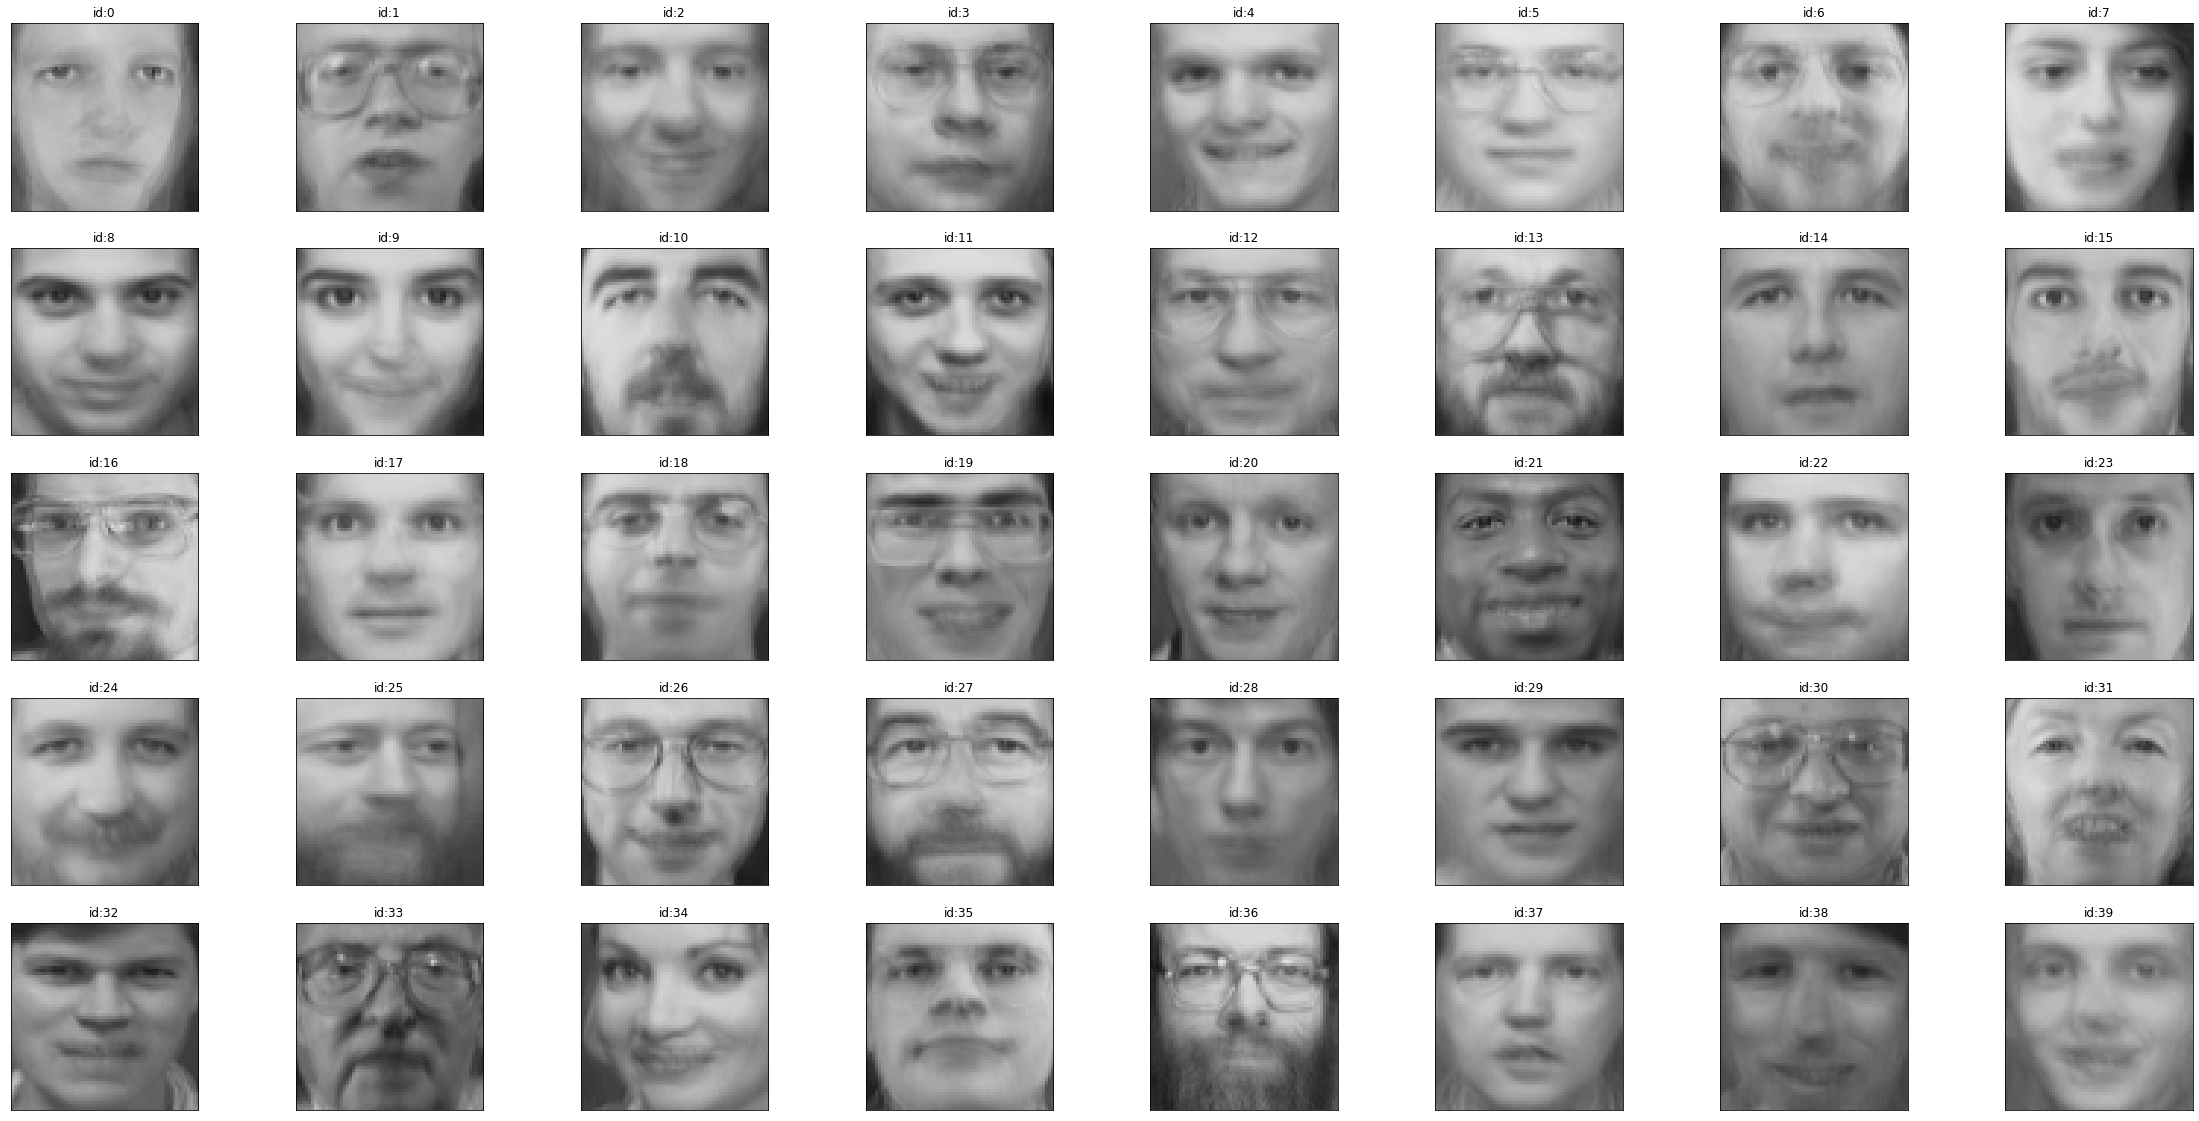

In [49]:
number= 40
cols = 8
rows = int(number/cols)
fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(40,20))
axarr = axarr.flatten()

for i in range(number):
    axarr[i].imshow(recon_img[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("id:{}".format(i))

In [34]:
recon_num=1
show_no=1
recon_img=[]
for i in range(1, 41):
    for j in range(1, 11):
        im = list(np.array(Image.open("./results/recon_"+ str(j) + "_"+str(i)+".png")))
        recon_img.append(im)

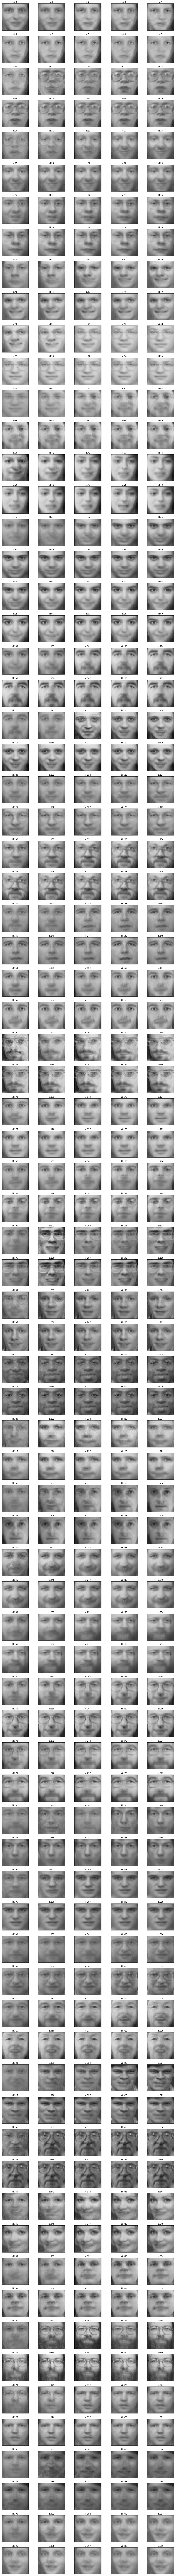

In [35]:
number= 400
cols = 5
rows = int(number/cols)
fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(20,300))
axarr = axarr.flatten()

for i in range(number):
    axarr[i].imshow(recon_img[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("id:{}".format(i))

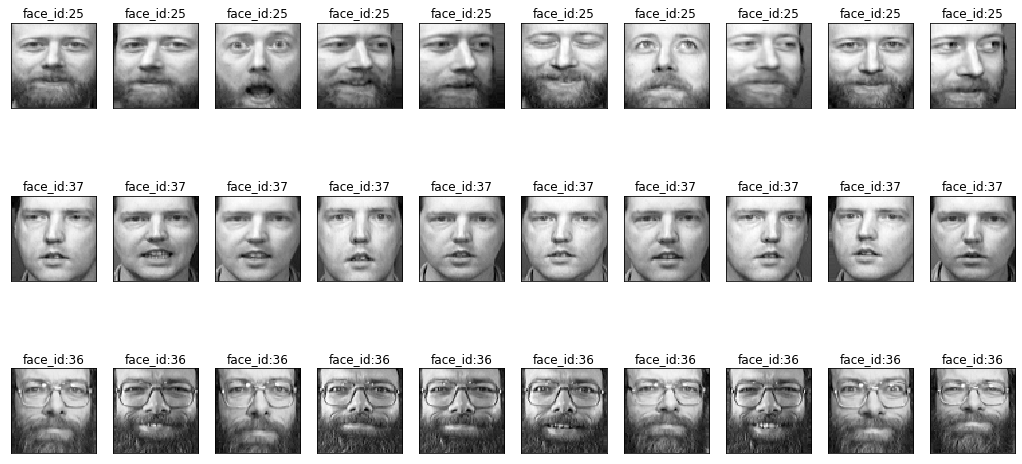

In [62]:
show_target(images=data, subject_ids = [25, 37, 36])